# Measurement from 2020-12-18 and 19

Files are in: /Users/hkromer/02_PhD/02_Data/13.new_chamber/2019-12-18.Testing_without_extraction.xlsx

and 

/Users/hkromer/02_PhD/02_Data/13.new_chamber/2019-12-19.Loading.Testing_without_extraction.xlsx

Suppression electrode was already burned.

In [1]:
import numpy as np
import pandas as pd
import pymysql
import sqlalchemy as sql
import matplotlib.pyplot as plt
import matplotlib.dates as md
# import seaborn as sns
# sns.set()
import getopt
import sys
import datetime
from scipy.interpolate import interp1d
from NGDataObject import NGDataObject
from scipy.optimize import curve_fit
from scipy import optimize

#*******************************
# CONSTANTS
#*******************************
# connection to database
CREDENTIALS_FILE = '/Users/hkromer/02_PhD/01.github/dash_NG/credentials.pw'
DB = "NG_twofast_DB" # name of the database
HOST = "twofast-RPi3-0"  # database host

# LOOKUP TABLES
LUT_PRESSURE_ION_SOURCE = "/Users/hkromer/02_PhD/01.github/phd/01_neutron_generator_contol/LUT_pressure_ion_source.txt"

# 2019-12-18

In [2]:
DAY = "2019-12-18"
PATH = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2019-12-18.without_suppression_fail/'


## LOAD FROM DATABASE

In [ ]:
# reference detectors
# dose
# HV

# read password and user to connect to database
credentials = pd.read_csv(CREDENTIALS_FILE, header=0)
user = credentials['username'].values[0]
pw = credentials['password'].values[0]


#*******************************
# GET DATA
#*******************************

# connect to DB
con = NGDataObject(host = HOST, database=DB, user=user, password=pw)

# get dose
query = "SELECT * FROM data_dose WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_dose = con.get_from_database(query=query)

# get HV
query = "SELECT * FROM data_HV WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_hv = con.get_from_database(query=query)
data_hv['HV_current_x100'] = data_hv['HV_current']*100.0

# get pressure
query = "SELECT * FROM data_pressure WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_pressure = con.get_from_database(query=query)



### Save to file

In [ ]:
data_dose.to_csv(f'{PATH}/{DAY}_dose.csv')
data_hv.to_csv(f'{PATH}/{DAY}_hv.csv')
data_pressure.to_csv(f'{PATH}/{DAY}_pressure.csv')

## Load from csv

In [3]:
data_dose = pd.read_csv(f'{PATH}/{DAY}_dose.csv', index_col=0)
data_hv = pd.read_csv(f'{PATH}/{DAY}_hv.csv', index_col=0)
data_pressure = pd.read_csv(f'{PATH}/{DAY}_pressure.csv', index_col=0)

for df in [data_dose, data_hv, data_pressure]:
    df.index = pd.to_datetime(df.index)
    

In [4]:
time_start = f"{DAY} 15:30:00"
time_end = f"{DAY} 19:20:00"


data_dose = data_dose.loc[time_start:time_end, :]
data_hv = data_hv.loc[time_start:time_end, :]
data_pressure = data_pressure.loc[time_start:time_end, :]

## put all on one dataframe

In [5]:
def resample_30_seconds(df, cols, range_start, range_end):
    """
    Takes the a grouped df (grouped by day) and resamples the columns cols in 10s
    OUTPUT:
        - dataframe
    """

    d = {}

    s = pd.date_range(start=range_start, end=range_end, freq='10S')
    df_out = pd.DataFrame(pd.Series(s, name='time')).set_index('time')
    for col in cols:
        d[col] = df[col].resample('10S').mean()

    this_d = pd.DataFrame(d)

    df_out = df_out.merge(this_d, left_on=df_out.index, right_on=this_d.index, how='outer')
    df_out = df_out.set_index('key_0')
    df_out.index.name ='time'    
    
    return df_out

In [6]:
data_hv = resample_30_seconds(data_hv, ['HV_current', 'HV_voltage'], time_start, time_end)
data_dose = resample_30_seconds(data_dose, ['dose_corrected'], time_start, time_end)

data = pd.merge(data_hv, data_dose, left_index=True, right_index=True, how='outer')


In [7]:
# time difference since the start time
data['time_delta_minutes'] = data.index
data['time_delta_minutes'] = data['time_delta_minutes'].apply(lambda x: (x - data.index[0]).seconds/60)


In [8]:

import os, matplotlib
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
from matplotlib.ticker import AutoMinorLocator
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

In [12]:
OUTPUT_FOLDER = '/Users/hkromer/polybox/Thesis/Appendices/AppendixB/Figures//First_operation_wo_suppression/'
FIGNAME = 'First_operation_wo_suppression'

In [13]:
data_mcnp_LUT = pd.read_csv("/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-03-01.MCNP_2e8nps/LUT_dose_output.csv", index_col=0) # output per 100 muSv/hr
# take 100 kV
dose_to_output = data_mcnp_LUT.loc[100, 'E']
dose_to_output = dose_to_output / 100 # per 1 muSv/h
data['output'] = data['dose_corrected'] * dose_to_output
data.head()
dose_to_output # output per 1 muSv/hr

34719.54196076212

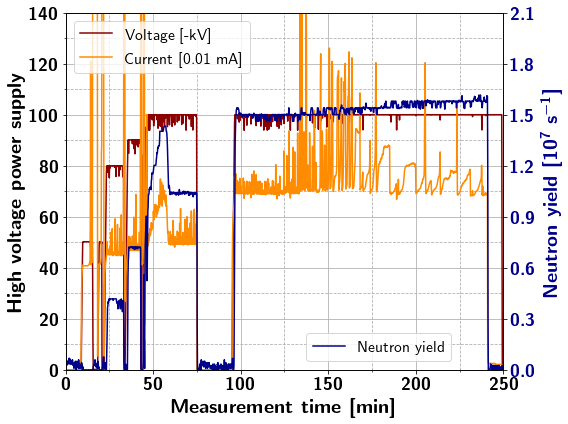

In [25]:
fig = plt.figure(figsize=(8,6))
fs = 20

plt.plot(data['time_delta_minutes'].values, data['HV_voltage'].values, label='Voltage [-kV]', color='darkred')
plt.plot(data['time_delta_minutes'].values, data['HV_current'].values * 100, label='Current [0.01 mA]', color='darkorange')

ax = plt.gca()

_ = plt.xlabel(r'\textbf{Measurement time [min]}',fontsize=fs)
_ = ax.set_ylabel(r'\textbf{High voltage power supply}', color='black',fontsize=fs)
_ = plt.legend(loc="upper left", fontsize=fs-4)
# minor ticks x
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
# minor ticks y
minor_locator = AutoMinorLocator(2)
ax.yaxis.set_minor_locator(minor_locator)
# tick font size
ax.tick_params('x', colors='black', labelsize=fs-2)	
ax.tick_params('y', colors='black', labelsize=fs-2)	
# grid
ax.grid(b=True, which='major', linestyle='-')#, color='gray')
ax.grid(b=True, which='minor', linestyle='--')#, color='gray')


ax2 = ax.twinx()
# Turns off grid on the secondary (right) Axis.
ax2.grid(False)
ax2.set_ylabel(r"\textbf{Neutron yield [10$^{7}$ s$^{-1}$]}", color='darkblue',fontsize=fs)
ax2.tick_params(axis='y', labelcolor='darkblue', labelsize=fs-2)
plt.plot(data['time_delta_minutes'].values, data['output'].values*1e-7, label='Neutron yield', color='darkblue')

_ = ax2.legend(loc=(0.55, 0.025), fontsize=fs-4)
ax.set_ylim(0, 140)
ax.set_xlim(0, 250)
ax2.set_ylim(0, 2.1)
ax2.set_yticks(np.arange(0, 2.1+0.3, 0.3))
plt.tight_layout()
plt.savefig(f'{OUTPUT_FOLDER}/{FIGNAME}.pdf')
plt.show()

# 2019-12-19

In [15]:
DAY = "2019-12-19"
PATH = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2019-12-19.without_suppression_fail/'


## LOAD FROM DATABASE

In [ ]:
# reference detectors
# dose
# HV

# read password and user to connect to database
credentials = pd.read_csv(CREDENTIALS_FILE, header=0)
user = credentials['username'].values[0]
pw = credentials['password'].values[0]


#*******************************
# GET DATA
#*******************************

# connect to DB
con = NGDataObject(host = HOST, database=DB, user=user, password=pw)

# get dose
query = "SELECT * FROM data_dose WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_dose = con.get_from_database(query=query)

# get HV
query = "SELECT * FROM data_HV WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_hv = con.get_from_database(query=query)
data_hv['HV_current_x100'] = data_hv['HV_current']*100.0

# get pressure
query = "SELECT * FROM data_pressure WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_pressure = con.get_from_database(query=query)



### Save to file

In [31]:
data_dose.to_csv(f'{PATH}/{DAY}_dose.csv')
data_hv.to_csv(f'{PATH}/{DAY}_hv.csv')
data_pressure.to_csv(f'{PATH}/{DAY}_pressure.csv')

## Load from csv

In [16]:
DAY = "2019-12-19"
PATH = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2019-12-19.without_suppression_fail/'
data_dose = pd.read_csv(f'{PATH}/{DAY}_dose.csv', index_col=0)
data_hv = pd.read_csv(f'{PATH}/{DAY}_hv.csv', index_col=0)
data_pressure = pd.read_csv(f'{PATH}/{DAY}_pressure.csv', index_col=0)

for df in [data_dose, data_hv, data_pressure]:
    df.index = pd.to_datetime(df.index)
    
data_dose.head()

,dose_corrected
time,
2019-12-19 11:20:00,12.382924
2019-12-19 11:20:10,7.589534
2019-12-19 11:20:20,12.382924
2019-12-19 11:20:30,9.986229
2019-12-19 11:20:40,7.589534


In [17]:
time_start = f"{DAY} 11:20:00"
time_end = f"{DAY} 15:30:00"


data_dose = data_dose.loc[time_start:time_end, :]
data_hv = data_hv.loc[time_start:time_end, :]
data_pressure = data_pressure.loc[time_start:time_end, :]

## put all on one dataframe

In [18]:
def resample_30_seconds(df, cols, range_start, range_end):
    """
    Takes the a grouped df (grouped by day) and resamples the columns cols in 10s
    OUTPUT:
        - dataframe
    """

    d = {}

    s = pd.date_range(start=range_start, end=range_end, freq='10S')
    df_out = pd.DataFrame(pd.Series(s, name='time')).set_index('time')
    for col in cols:
        d[col] = df[col].resample('10S').mean()

    this_d = pd.DataFrame(d)

    df_out = df_out.merge(this_d, left_on=df_out.index, right_on=this_d.index, how='outer')
    df_out = df_out.set_index('key_0')
    df_out.index.name ='time'    
    
    return df_out

In [19]:
data_hv = resample_30_seconds(data_hv, ['HV_current', 'HV_voltage'], time_start, time_end)
data_dose = resample_30_seconds(data_dose, ['dose_corrected'], time_start, time_end)

data = pd.merge(data_hv, data_dose, left_index=True, right_index=True, how='outer')


In [20]:
# time difference since the start time
data['time_delta_minutes'] = data.index
data['time_delta_minutes'] = data['time_delta_minutes'].apply(lambda x: (x - data.index[0]).seconds/60)


In [21]:

import os, matplotlib
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
from matplotlib.ticker import AutoMinorLocator
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

In [22]:
OUTPUT_FOLDER = '/Users/hkromer/polybox/Thesis/Appendices/AppendixB/Figures/First_operation_wo_suppression/'
FIGNAME = 'First_operation_wo_suppression_2'

In [23]:
data_mcnp_LUT = pd.read_csv("/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-03-01.MCNP_2e8nps/LUT_dose_output.csv", index_col=0) # output per 100 muSv/hr
# take 100 kV
dose_to_output = data_mcnp_LUT.loc[100, 'E']
dose_to_output = dose_to_output / 100 # per 1 muSv/h
data['output'] = data['dose_corrected'] * dose_to_output
data.head()
dose_to_output # output per 1 muSv/hr

34719.54196076212

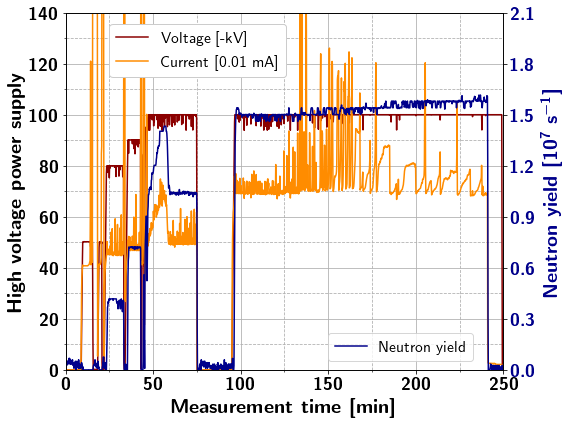

In [26]:
fig = plt.figure(figsize=(8,6))
fs = 20

plt.plot(data['time_delta_minutes'].values, data['HV_voltage'].values, label='Voltage [-kV]', color='darkred')
plt.plot(data['time_delta_minutes'].values, data['HV_current'].values * 100, label='Current [0.01 mA]', color='darkorange')

ax = plt.gca()

_ = plt.xlabel(r'\textbf{Measurement time [min]}',fontsize=fs)
_ = ax.set_ylabel(r'\textbf{High voltage power supply}', color='black',fontsize=fs)
_ = plt.legend(loc=(0.1, 0.82), fontsize=fs-4, framealpha=1)
# minor ticks x
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
# minor ticks y
minor_locator = AutoMinorLocator(2)
ax.yaxis.set_minor_locator(minor_locator)
# tick font size
ax.tick_params('x', colors='black', labelsize=fs-2)	
ax.tick_params('y', colors='black', labelsize=fs-2)	
# grid
ax.grid(b=True, which='major', linestyle='-')#, color='gray')
ax.grid(b=True, which='minor', linestyle='--')#, color='gray')


ax2 = ax.twinx()
# Turns off grid on the secondary (right) Axis.
ax2.grid(False)
ax2.set_ylabel(r"\textbf{Neutron yield [10$^{7}$ s$^{-1}$]}", color='darkblue',fontsize=fs)
ax2.tick_params(axis='y', labelcolor='darkblue', labelsize=fs-2)
plt.plot(data['time_delta_minutes'].values, data['output'].values*1e-7, label='Neutron yield', color='darkblue')

_ = ax2.legend(loc=(0.60, 0.025), fontsize=fs-4)
ax.set_xlim(0, 250)
ax.set_ylim(0, 140)
ax2.set_ylim(0, 2.1)
ax2.set_yticks(np.arange(0, 2.1+0.3, 0.3))
plt.tight_layout()
plt.savefig(f'{OUTPUT_FOLDER}/{FIGNAME}.pdf')
plt.show()

In [ ]:
data